In [179]:
import os
import time
import random
import functools
import multiprocessing

import pandas as pd
import numpy as np
import cv2
from tqdm.notebook import tqdm
from tqdm.contrib.concurrent import process_map
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.express as px

from metrics import (
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index,
    compile_metrics
)
from sm_naive_sliding_window import (
    calculate_disparity_map,
    calculate_disparities_for_row
)
from stereo_reconstruction import reconstruct_3d_scene

In [63]:
path_data = os.path.join(os.getcwd(), 'data_modified')

image_names = os.listdir(path_data)
image_sets = sorted(list(set([x.split('_')[0] for x in image_names])))

In [64]:
image_sets

['art', 'books', 'dolls', 'laundry', 'moebius', 'reindeer']

## Compile metrics for numba

In [65]:
x = 13

bls = np.array([
    list(range(x)),
    list(range(x, 2*x)),
    list(range(2*x, 3*x))
])

temp = np.array([
    [4,5,6],
    [17,18,19],
    [30,31,32]
])
compile_metrics(temp, bls[:, 10:13])

## Define a parameter grid to run the experiments

In [66]:
block_sizes = list(range(3, 15, 2))

max_distances = list(range(40, 80, 4))

metrics = [
    normalized_cross_correlation,
    sum_of_squared_differences,
    normalized_sum_of_squared_differences,
    sum_of_absolute_differences,
    structural_similarity_index
]

In [67]:
params = []

for metr in metrics:
    for bs in block_sizes:
        for md in max_distances:
            params.append((metr, bs, md))

In [68]:
len(params)

300

## There will be 300 unique experiments for each dataset

In [69]:
path_disparity_maps = os.path.join(os.getcwd(), 'disparity_maps')
results = []
n_processes = 5


for img_set in tqdm(image_sets):
    
    img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
    img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'))
    img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)
    
    img_left_gr = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
    img_right_gr = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
    
    rows = list(range(img_left.shape[0]))
    
    for par in tqdm(params):
        
        metr, bs, md = par
        
        func = functools.partial(
            calculate_disparities_for_row, 
            left_image=img_left_gr, 
            right_image=img_right_gr,
            metric=metr, 
            block_size=bs,
            max_distance=md
        )
        start = time.time()
        
        with multiprocessing.Pool(processes=n_processes) as pool:
            dpm = pool.map(func, rows)
        
        elapsed = round(time.time() - start, 4)
        
        dpm = sorted(dpm, key=lambda x: x[0])
        dpm = np.array([el[1] for el in dpm])
        
        file_name = f'disp_{metr.__name__}_{img_set}_{bs}_{md}.png'
        plt.imsave(os.path.join(path_disparity_maps, file_name), dpm, cmap='gray')
        score = metr(img_disp, dpm)
        results.append({
            'dataset': img_set,
            'metric': metr.__name__,
            'block_size': bs,
            'max_distance': md,
            'dpm_file_name': file_name,
            'score': score,
            'execution_time': elapsed
        })

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [70]:
df = pd.DataFrame(results)

In [177]:
df.head()

dataset                        metric  block_size  max_distance  \
0     art  normalized_cross_correlation           3            40   
1     art  normalized_cross_correlation           3            44   
2     art  normalized_cross_correlation           3            48   
3     art  normalized_cross_correlation           3            52   
4     art  normalized_cross_correlation           3            56   

                                    dpm_file_name     score  execution_time  
0  disp_normalized_cross_correlation_art_3_40.png  0.069667          2.1998  
1  disp_normalized_cross_correlation_art_3_44.png  0.054464          2.2594  
2  disp_normalized_cross_correlation_art_3_48.png  0.007456          2.2998  
3  disp_normalized_cross_correlation_art_3_52.png -0.029181          2.3177  
4  disp_normalized_cross_correlation_art_3_56.png -0.103260          2.4092

In [214]:
path_results = os.path.join(os.getcwd(), 'results')

if not os.path.isdir(path_results):
    os.mkdir(path_results)

df.to_csv(os.path.join(path_results, 'sm_naive_sw_results.csv'), index=False)

## NSSD took the most time to compute on average, while SAD and SSD the least

Text(0, 0.5, 'Execution time (seconds)')

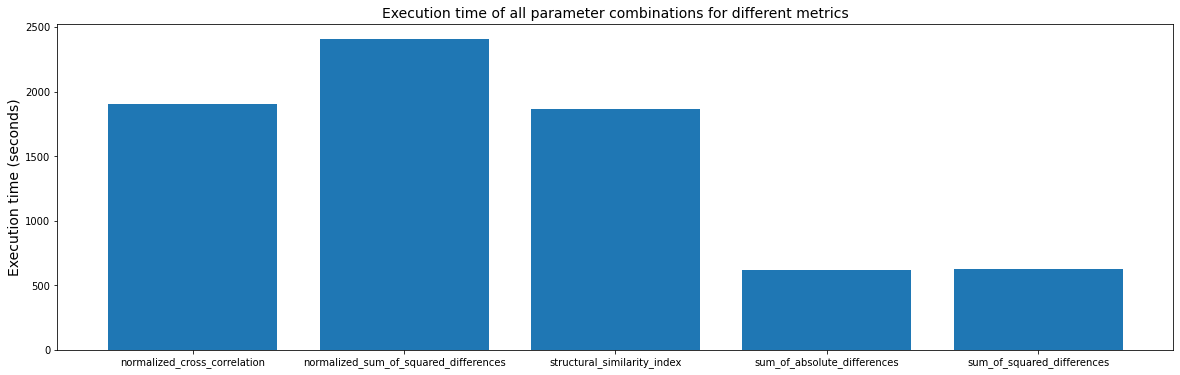

In [234]:
d_metrics_exec_time = df.groupby('metric')[['execution_time']].sum().to_dict()

fig = plt.figure(figsize=(20, 6))
plt.bar(
    d_metrics_exec_time['execution_time'].keys(), 
    d_metrics_exec_time['execution_time'].values()

)
plt.title('Execution time of all parameter combinations for different metrics', fontsize=14)
plt.ylabel('Execution time (seconds)', fontsize=14)

## Average scores achieved by comparing the ground truth disparity maps to the computed ones per dataset

In [235]:
df.groupby(['dataset', 'metric'])[['score']].mean()

score
dataset  metric                                             
art      normalized_cross_correlation          -1.899124e-01
         normalized_sum_of_squared_differences  1.618440e+00
         structural_similarity_index           -8.562141e-02
         sum_of_absolute_differences            1.745129e+07
         sum_of_squared_differences             1.922285e+09
books    normalized_cross_correlation          -3.370614e-01
         normalized_sum_of_squared_differences  1.328105e+00
         structural_similarity_index           -1.436011e-01
         sum_of_absolute_differences            1.741062e+07
         sum_of_squared_differences             1.857023e+09
dolls    normalized_cross_correlation          -2.902223e-01
         normalized_sum_of_squared_differences  1.420028e+00
         structural_similarity_index           -1.299371e-01
         sum_of_absolute_differences            1.795948e+07
         sum_of_squared_differences             2.003007e+09
laundry  normalized_cross_correlation          -2.300781e-01
         normalized_sum_of_squared_differences  1.542580e+00
         structural_similarity_index           -9.610021e-02
         sum_of_absolute_differences            1.510916e+07
         sum_of_squared_differences             1.459576e+09
moebius  normalized_cross_correlation          -1.882440e-01
         normalized_sum_of_squared_differences  1.622184e+00
         structural_similarity_index           -8.532578e-02
         sum_of_absolute_differences            1.381452e+07
         sum_of_squared_differences             1.251119e+09
reindeer normalized_cross_correlation          -4.083635e-02
         normalized_sum_of_squared_differences  1.918275e+00
         structural_similarity_index           -3.485299e-02
         sum_of_absolute_differences            1.684618e+07
         sum_of_squared_differences             2.041134e+09

## More similar blocks are found towards 70 pixels, almost for all metrics

In [311]:
df.loc[
    (df['dataset'] == 'reindeer')
].groupby(['metric', 'max_distance'])[['score']].mean().sort_values('score')

score
metric                                max_distance              
normalized_cross_correlation          68           -3.154551e-01
                                      72           -3.118393e-01
                                      76           -3.053482e-01
                                      64           -2.653865e-01
structural_similarity_index           68           -1.107348e-01
                                      72           -1.107050e-01
                                      76           -1.097475e-01
                                      64           -9.714059e-02
normalized_cross_correlation          60           -9.123541e-02
structural_similarity_index           60           -4.552088e-02
                                      56           -1.124920e-02
                                      52            1.497508e-02
normalized_cross_correlation          56            2.807467e-02
structural_similarity_index           48            3.087492e-02
                                      44            4.242607e-02
                                      40            4.829191e-02
normalized_cross_correlation          52            1.220805e-01
                                      48            1.756961e-01
                                      44            2.501534e-01
                                      40            3.048964e-01
normalized_sum_of_squared_differences 68            1.369453e+00
                                      72            1.376824e+00
                                      76            1.389873e+00
                                      64            1.469429e+00
                                      60            1.817486e+00
                                      56            2.055947e+00
                                      52            2.243821e+00
                                      48            2.350926e+00
                                      44            2.499767e+00
                                      40            2.609229e+00
sum_of_absolute_differences           76            1.561802e+07
                                      72            1.578230e+07
                                      68            1.598843e+07
                                      64            1.625934e+07
                                      60            1.659238e+07
                                      56            1.698152e+07
                                      52            1.731712e+07
                                      48            1.760158e+07
                                      44            1.798207e+07
                                      40            1.833903e+07
sum_of_squared_differences            76            1.823119e+09
                                      72            1.828640e+09
                                      68            1.837757e+09
                                      64            1.864931e+09
                                      60            1.944826e+09
                                      56            2.026299e+09
                                      52            2.135065e+09
                                      48            2.219636e+09
                                      44            2.321068e+09
                                      40            2.409998e+09

## Evaluation scores depends on both the metric and the block size. For NCC, the best result was achieved with a block size of 5, while for SSIM and for SAD, the best score was obtained with a block size of 9. For SSD the best score was achieved with a block size of 13.

In [320]:
df.loc[
    (
        (df['dataset'] == 'reindeer')
        & (df['max_distance'].isin(list(range(66, 76))))
    )
].groupby(['metric', 'block_size'])[['score']].mean().sort_values('score')

score
metric                                block_size              
normalized_cross_correlation          5          -3.512957e-01
                                      7          -3.326239e-01
                                      3          -3.255046e-01
                                      9          -3.121212e-01
                                      11         -2.897780e-01
                                      13         -2.705600e-01
structural_similarity_index           9          -1.128518e-01
                                      7          -1.128276e-01
                                      5          -1.124111e-01
                                      11         -1.111824e-01
                                      13         -1.082725e-01
                                      3          -1.067738e-01
normalized_sum_of_squared_differences 5           1.297419e+00
                                      7           1.334744e+00
                                      3           1.351587e+00
                                      9           1.375758e+00
                                      11          1.420444e+00
                                      13          1.458880e+00
sum_of_absolute_differences           9           1.585402e+07
                                      13          1.586509e+07
                                      7           1.586546e+07
                                      11          1.586606e+07
                                      5           1.590332e+07
                                      3           1.595822e+07
sum_of_squared_differences            13          1.823020e+09
                                      11          1.824217e+09
                                      9           1.825188e+09
                                      7           1.828177e+09
                                      5           1.839812e+09
                                      3           1.858778e+09

In [212]:
def show_random_disparity_maps(
    df: pd.DataFrame, 
    image_set: str,
    path_data: str, 
    n: int = 20
) -> None:
    """
    """
    indices = random.sample(df.loc[(df['dataset'] == image_set)].index.tolist(), k=n)
    file_names = df.loc[indices, 'dpm_file_name'].tolist()
    
    n_cols = n // 5
    n_rows = n // n_cols
    
    plt.figure(figsize=(16, 16))
    gs = gridspec.GridSpec(n_rows, n_cols)
    gs.update(wspace=0.15, hspace=0.1)
    
    for i, fn in enumerate(file_names):
        img = cv2.imread(os.path.join(path_data, fn), cv2.IMREAD_GRAYSCALE)
        ax = plt.subplot(gs[i])
        ax.imshow(img, cmap='gray')
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        
    plt.subplots_adjust(top=0.94)
    plt.show()

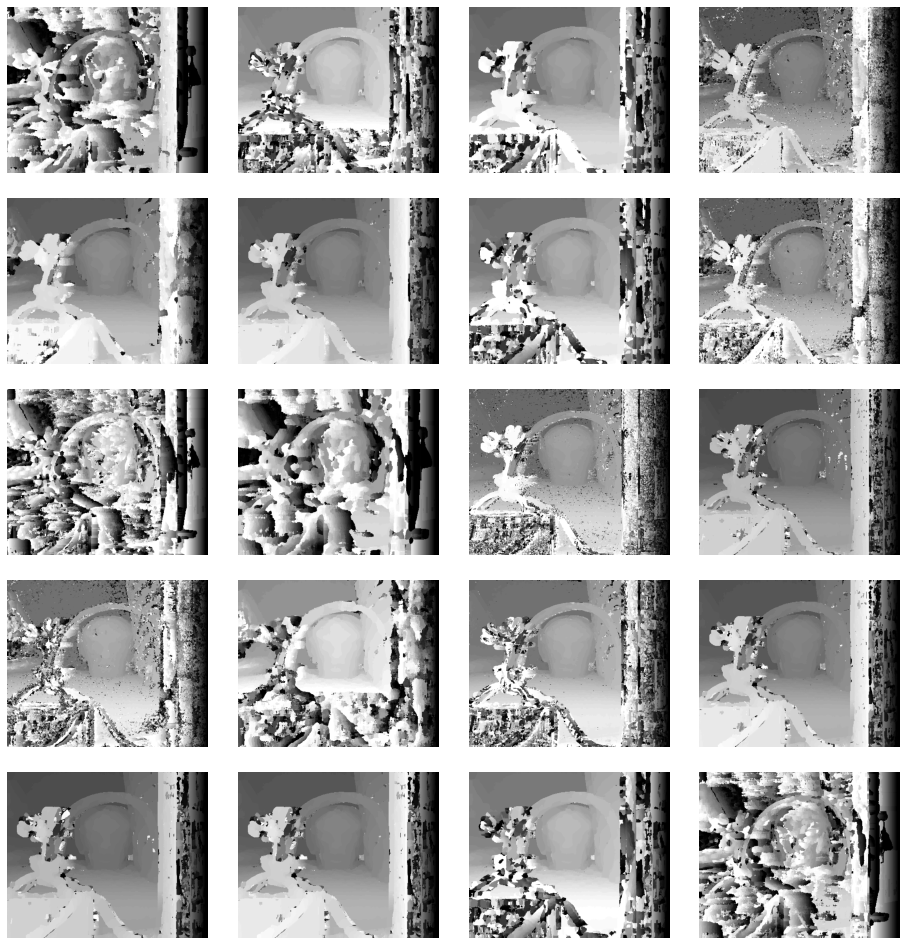

In [213]:
show_random_disparity_maps(df, 'reindeer', path_disparity_maps)

## Up to a certain point smoother disparity maps obtained with less noise as the block size increases

In [280]:
img_set = 'reindeer'
metric = 'normalized_cross_correlation'
md = 60

df_bss = df.loc[
    (
        (df['dataset'] == img_set)
        & (df['metric'] == metric)
        & (df['max_distance'] == md)
    )
].reset_index(drop=True).copy()

file_names_bss = list(df_bss.loc[:, ['dpm_file_name', 'block_size']].itertuples(name=None, index=False))

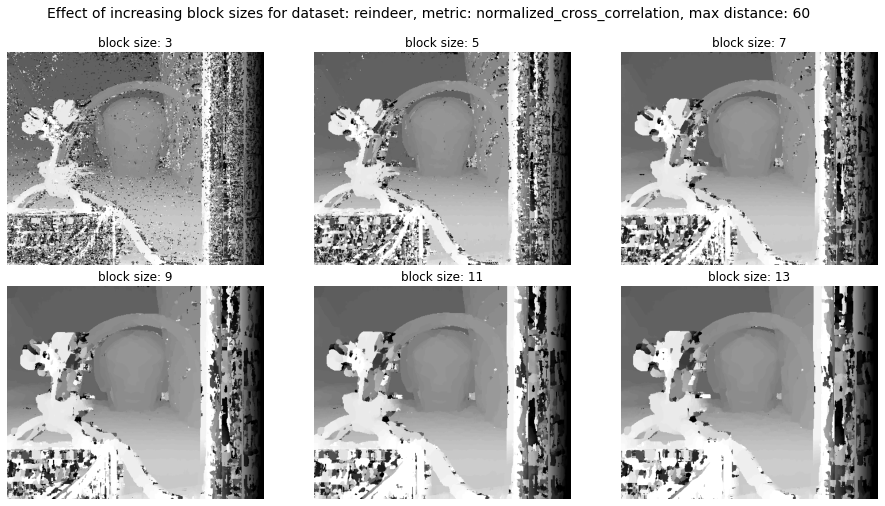

In [281]:
plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.1, hspace=0.1)

for i, el in enumerate(file_names_bss):
    fn, bs = el
    img = cv2.imread(os.path.join(path_disparity_maps, fn), cv2.IMREAD_GRAYSCALE)
    ax = plt.subplot(gs[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f'block size: {bs}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.9)
plt.suptitle(
    f'Effect of increasing block sizes for dataset: '
    f'{img_set}, metric: {metric}, max distance: {md}',
    fontsize=14
)
plt.show()

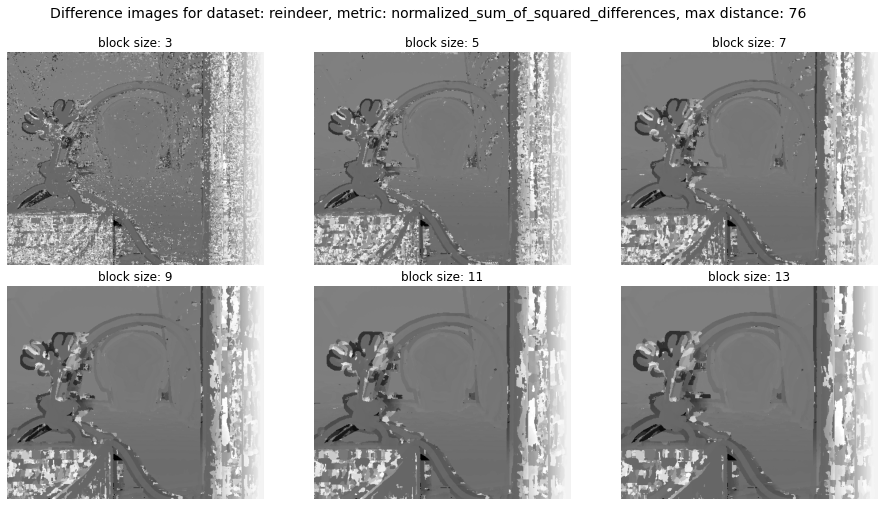

In [321]:
img_disp = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)

# described at https://vision.middlebury.edu/stereo/data/scenes2005/
img_disp = img_disp / 3

plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.1, hspace=0.1)

for i, el in enumerate(file_names_bss):
    fn, bs = el
    img = cv2.imread(os.path.join(path_disparity_maps, fn), cv2.IMREAD_GRAYSCALE) / 3
    img_diff = img_disp - img
    ax = plt.subplot(gs[i])
    ax.imshow(img_diff, cmap='gray')
    ax.set_title(f'block size: {bs}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.9)
plt.suptitle(
    f'Difference images for dataset: '
    f'{img_set}, metric: {metric}, max distance: {md}',
    fontsize=14
)
plt.show()

In [285]:
img_set = 'reindeer'
metric = 'normalized_cross_correlation'
bs = 9

df_mds = df.loc[
    (
        (df['dataset'] == img_set)
        & (df['metric'] == metric)
        & (df['block_size'] == bs)
    )
].reset_index(drop=True).copy()

file_names_mds = list(df_mds.loc[:, ['dpm_file_name', 'max_distance']].itertuples(name=None, index=False))

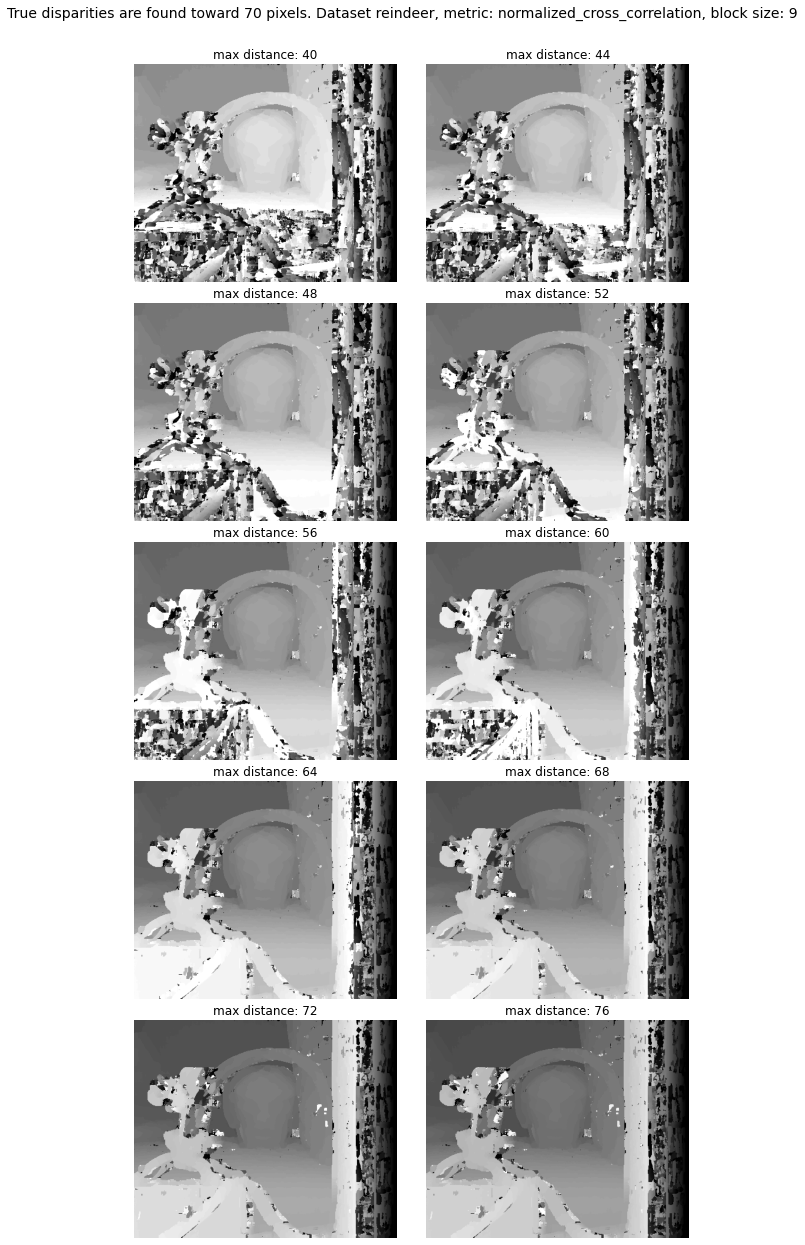

In [295]:
plt.figure(figsize=(10, 20))
gs = gridspec.GridSpec(5, 2)
gs.update(wspace=0.1, hspace=0.1)

for i, el in enumerate(file_names_mds):
    fn, md = el
    img = cv2.imread(os.path.join(path_disparity_maps, fn), cv2.IMREAD_GRAYSCALE)
    ax = plt.subplot(gs[i])
    ax.imshow(img, cmap='gray')
    ax.set_title(f'max distance: {md}')
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')

plt.subplots_adjust(top=0.94)
plt.suptitle(
    f'True disparities are found toward 70 pixels. Dataset '
    f'{img_set}, metric: {metric}, block size: {bs}',
    fontsize=14
)
plt.show()

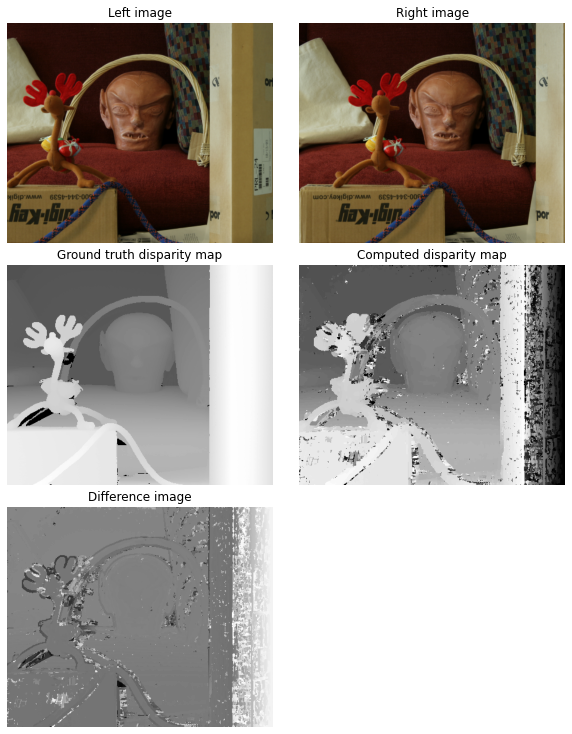

In [322]:
img_set = 'reindeer'
metric = 'normalized_sum_of_squared_differences'

df_dpms = df.loc[
    (
        (df['metric'] == metric)
        &
        (df['dataset'] == img_set)
    )
].sort_values('score').reset_index(drop=True).copy()

fn_dpm = df_dpms.loc[0, 'dpm_file_name']

img_left = cv2.imread(os.path.join(path_data, f'{img_set}_left.png'))
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_right = cv2.imread(os.path.join(path_data, f'{img_set}_right.png'))
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
dpm = cv2.imread(os.path.join(path_disparity_maps, fn_dpm), cv2.IMREAD_GRAYSCALE)
dpm = dpm / 3
dpm_gr = cv2.imread(os.path.join(path_data, f'{img_set}_disp.png'), cv2.IMREAD_GRAYSCALE)
dpm_gr = dpm_gr / 3
dpm_diff = dpm_gr - dpm

plt.figure(figsize=(10, 12))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.1)

ax = plt.subplot(gs[0])
ax.imshow(img_left)
ax.set_title('Left image')

ax = plt.subplot(gs[1])
ax.imshow(img_right)
ax.set_title('Right image')

ax = plt.subplot(gs[2])
ax.imshow(dpm_gr, cmap='gray')
ax.set_title('Ground truth disparity map')

ax = plt.subplot(gs[3])
ax.imshow(dpm, cmap='gray')
ax.set_title('Computed disparity map')

ax = plt.subplot(gs[4])
ax.imshow(dpm_diff, cmap='gray')
ax.set_title('Difference image')

for i in range(5):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    
plt.subplots_adjust(top=0.94)
plt.show()

## Stereo reconstruction of the 3D scene from the ground truth disparity map

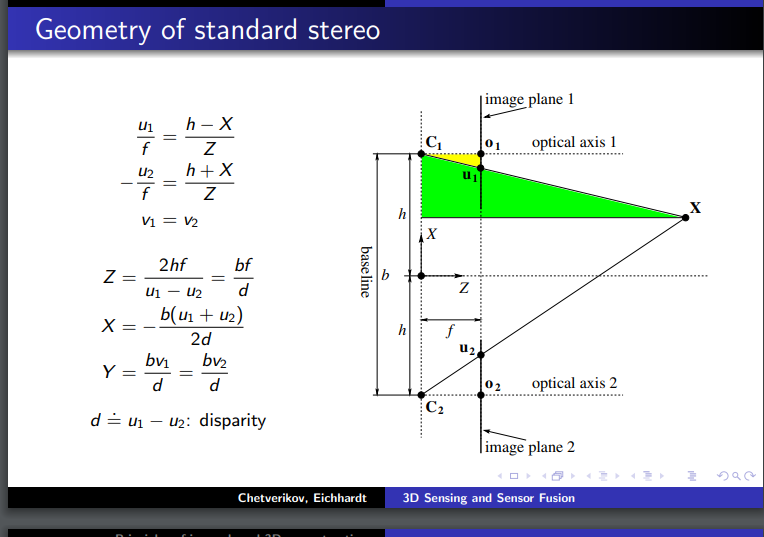

In [133]:
param_baseline = 160 # mm
param_focal_length = 3740 # pixels
dmin = 230

points_gr = reconstruct_3d_scene(
    img_left,
    dpm_gr, 
    param_baseline / 1000, 
    param_focal_length, 
    dmin
)

In [134]:
path_points = os.path.join(os.getcwd(), 'points_3d')
fn_points = f'{img_set}_3d_scene_gr.txt'

with open(os.path.join(path_points, fn_points), 'w') as file:
    for point in points_gr:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

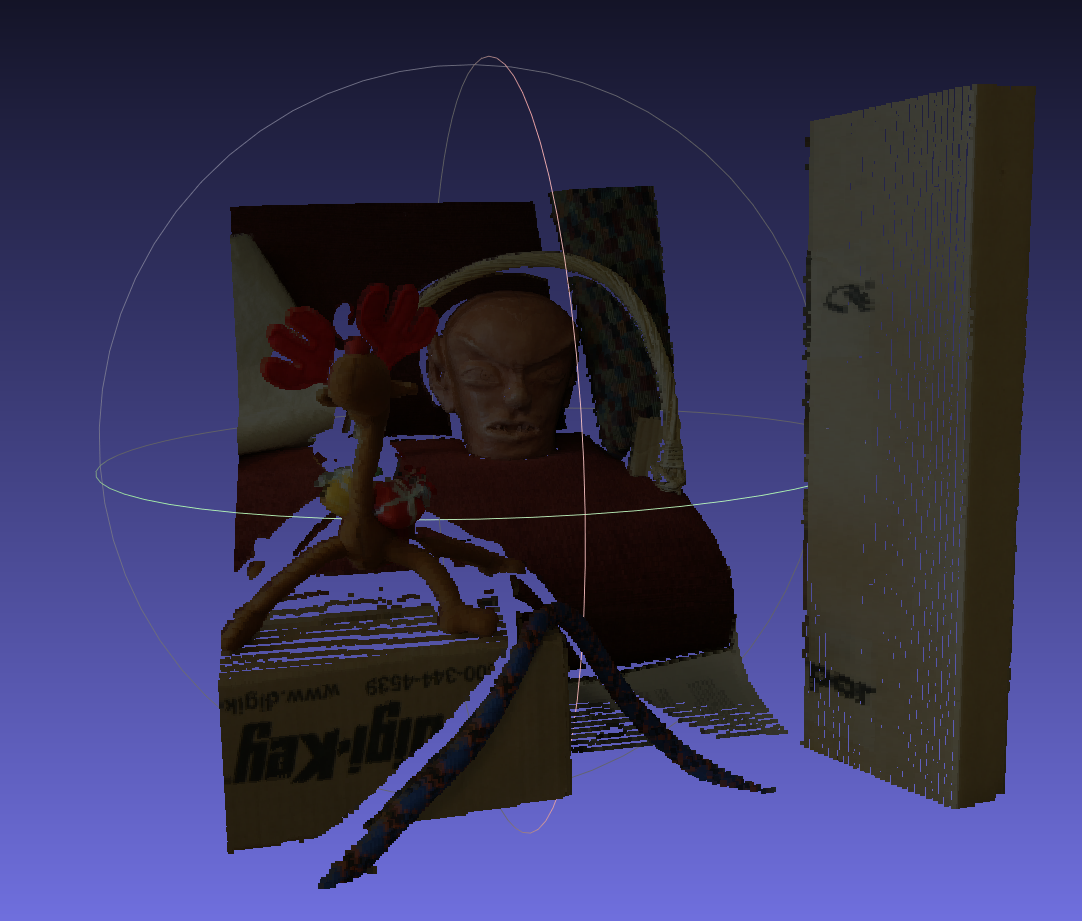

## Stereo reconstruction of the 3D scene from the computed disparity map

In [323]:
points_naive = reconstruct_3d_scene(
    img_left,
    dpm, 
    param_baseline / 1000, 
    param_focal_length, 
    dmin
)
fn_points = f'{img_set}_3d_scene_naive.txt'

with open(os.path.join(path_points, fn_points), 'w') as file:
    for point in points_naive:
        file.write(' '.join(str(p) for p in point))
        file.write('\n')

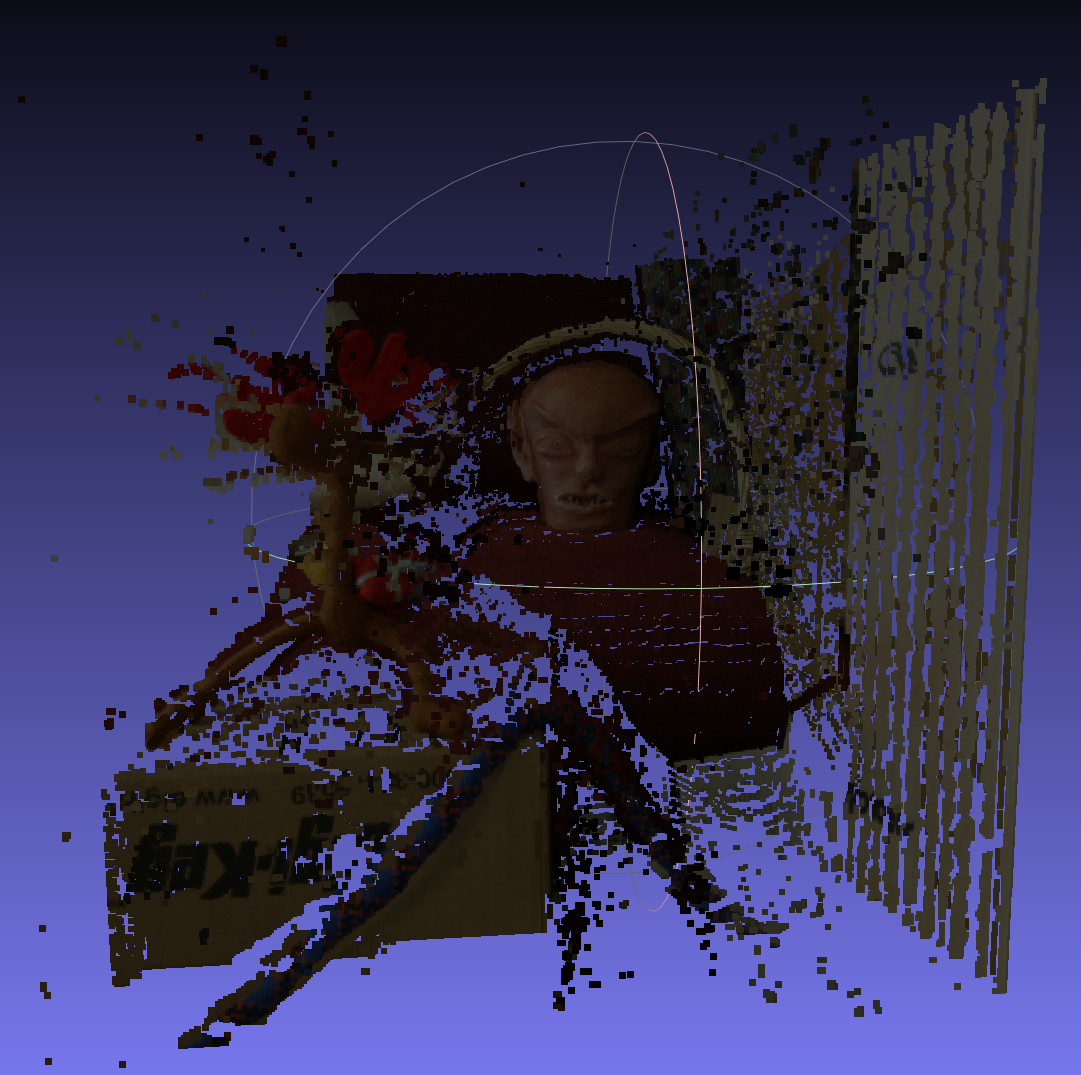